# Тренування word embeddings з нуля

Ми навчимо модель Word2Vec з нуля, перетворюючи необроблені текстові дані у значущі векторні представлення. Навчання моделі Word2Vec з нуля передбачає фіксацію контекстуальних зв’язків між словами в межах певного корпусу, кодування семантичних і синтаксичних нюансів у результуючі вектори слів.


Завдяки ітераційному навчанню з текстових корпусів модель Word2Vec поступово вивчає семантичну структуру мови, відображаючи слова у щільних безперервних векторних просторах. Керуючись цим процесом, ми усвідомлюємо як труднощі, так і переваги створення власних ембедингів, адаптованих до нашого набору даних, що дозволить нам розкрити приховану семантику й патерни в тексті.

In [ ]:
import re
import os
import gc
import datetime

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors #  implements word vectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

import matplotlib.cm as cm

import spacy

from tqdm.auto import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')
nltk.download('punkt')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# EDA

In [ ]:
# Ми продовжимо працювати з набором даних відгуків продуктів Amazon.
df = pd.read_csv('/content/drive/MyDrive/ds/Reviews.csv', index_col='Id')

# Quick data pre-processing

df = df.loc[df['Score']!=3]

df['sentiment'] = [1 if score in [4, 5] else 0 for score in df['Score']]

df = df.drop_duplicates().reset_index(drop=True)

df = df.drop_duplicates(subset={"UserId", "Time","Text"})

# Final size

df.shape

(364133, 10)

In [ ]:
# Contractions. Source http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
# Stop-words
stop_words = set(stopwords.words('english')).union({'also', 'would', 'much', 'many'})

negations = {
    'aren',
    "aren't",
    'couldn',
    "couldn't",
    'didn',
    "didn't",
    'doesn',
    "doesn't",
    'don',
    "don't",
    'hadn',
    "hadn't",
    'hasn',
    "hasn't",
    'haven',
    "haven't",
    'isn',
    "isn't",
    'mightn',
    "mightn't",
    'mustn',
    "mustn't",
    'needn',
    "needn't",
    'no',
    'nor',
    'not',
    'shan',
    "shan't",
    'shouldn',
    "shouldn't",
    'wasn',
    "wasn't",
    'weren',
    "weren't",
    'won',
    "won't",
    'wouldn',
    "wouldn't"
}

stop_words = stop_words.difference(negations)

In [ ]:
nlp = spacy.load("en_core_web_sm", disable = ['parser','ner'])

def normalize_text(raw_review):

    # Remove html tags
    text = re.sub("<[^>]*>", " ", raw_review) # match <> and everything in between. [^>] - match everything except >

    # Remove emails
    text = re.sub("\S*@\S*[\s]+", " ", text) # match non-whitespace characters, @ and a whitespaces in the end

    # remove links
    text = re.sub("https?:\/\/.*?[\s]+", " ", text) # match http, s - zero or once, //,
                                                    # any char 0-unlimited, whitespaces in the end

     # Convert to lower case, split into individual words
    text = text.lower().split()

    # Replace contractions with their full versions
    text = [contractions.get(word) if word in contractions else word
            for word in text]

    # Re-splitting for the correct stop-words extraction
    text = " ".join(text).split()

    # Remove stop words
    text = [word for word in text if not word in stop_words]

    text = " ".join(text)

    # Remove non-letters
    text = re.sub("[^a-zA-Z' ]", "", text) # match everything except letters and '


    # Stem words. Need to define porter stemmer above
    # text = [stemmer.stem(word) for word in text.split()]

    # Lemmatize words. Need to define lemmatizer above
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc if len(token.lemma_) > 1 ])

    # Remove excesive whitespaces
    text = re.sub("[\s]+", " ", text)

    # Join the words back into one string separated by space, and return the result.
    return(text)

In [ ]:
# Slicing dataset for demonstrative purposes

df = df.groupby('sentiment').sample(2500, random_state=42).reset_index(drop=True)

# Note: without resetting an index we slice over the original Id`s
df.shape

(5000, 10)

In [ ]:
df['text_normalized'] = df['Text'].progress_apply(normalize_text)

  0%|          | 0/5000 [00:00<?, ?it/s]

# From scratch

In [ ]:
# Напишемо функцію, яка створює список списків, що містить слова з кожного речення.
# Таким чином ми розбиваємо наші вхідні речення на токени, які буде вивчати модель векторного представлення.
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)

    return corpus

In [ ]:
corpus = build_corpus(df['text_normalized'])
corpus[0]

['suppose',
 'people',
 'might',
 'rate',
 'product',
 'high',
 'great',
 'substitute',
 'bisquik',
 'however',
 'not',
 'like',
 'everything',
 'make',
 'tasted',
 'like',
 'bisquik']

In [ ]:
# vector_size - Dimensionality of the word vectors ( розмірність векторів слів, тобто кількість вимірів, через які буде представлено кожне слово;)
# window - Maximum distance between the current and predicted word within a sentence (максимальна відстань між поточним і прогнозованим словом у реченні, тобто розмір контекстного вікна;)
# min_count - Ignores all words with total frequency lower than this (ігнорує всі слова із загальною частотою, нижчою за вказану.)

model_emb_from_scratch = word2vec.Word2Vec(corpus, vector_size=100, window=5, min_count=50, workers=4)

# saving vectors

# Створюємо папку, якщо вона ще не існує
os.makedirs('/content/drive/MyDrive/ds/saved_models', exist_ok=True)
model_emb_from_scratch.wv.save_word2vec_format('/content/drive/MyDrive/ds/saved_models/model_emb_from_scratch.bin', binary=True)

## Попередньо навчені embeddings

Однією з найбільших переваг використання word embeddings є можливість застосування попередньо навчених моделей. Ці моделі були навчені на величезних текстових корпусах, що дозволяє їм забезпечити високу якість векторних представлень слів.


переваги: зменшення обчислювальних витрат, покращення продуктивності кінцевих моделей і можливість переносу знань на нові задачі з обмеженою кількістю даних.

Хоч ці вектори і є якісними узагальненнями, їм може не вистачати специфічних доменних знань.

Завантажте векторні представлення за наступними посиланнями:

- Word2Vec: https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300

- GloVe: https://github.com/stanfordnlp/GloVe — glove.6B.50d

- FastText: https://www.kaggle.com/datasets/facebook/fasttext-wikinews?select=wiki-news-300d-1M.vec



Збережіть їх у папку pretrained_models.

In [ ]:
os.makedirs('/content/drive/MyDrive/ds/pretrained_models', exist_ok=True)

In [ ]:
# Створимо клас для роботи з попередньо навченими представленнями векторів.
class WordEmbedding:

    def __init__(self):
        self.model = {}

    def convert(self, source, ipnut_file_path, output_file_path):
        '''
        Converts word embeddings from GloVe format to Word2Vec format
        '''
        if source == 'glove':
            glove2word2vec(ipnut_file_path, output_file_path)
        elif source in ['word2vec', 'fasttext', 'from_scratch']:
            pass
        else:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

    def load(self, source, file_path):
        '''
        Loads a specified word embedding model from a file
        '''
        print(datetime.datetime.now(), 'start: loading', source)
        if source in ['glove', 'fasttext']:
            self.model[source] = gensim.models.KeyedVectors.load_word2vec_format(file_path)
        elif source in ['word2vec', 'from_scratch']:
            self.model[source] = gensim.models.KeyedVectors.load_word2vec_format(file_path, binary=True)
        else:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        print(datetime.datetime.now(), 'end: loading', source)

        return self

    def get_model(self, source):
        '''
        Retrieves the loaded word embedding model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        return self.model[source]

    def get_words(self, source, size=None):
        '''
        Retrieves a list of words from the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        if size is None:
            return [w for w in self.get_model(source=source).key_to_index]
        else:
            results = []
            for i, word in enumerate(self.get_model(source=source).key_to_index):
                if i >= size:
                    break
                results.append(word)
            return results

        return Exception('Unexpected flow')

    def get_dimension(self, source):
        '''
        Retrieves the dimension of word vectors in the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        return self.get_model(source=source).vectors[0].shape[0]

    def get_vectors(self, source, words=None):
        '''
        Retrieves vectors for specified words or for all words in the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        if words is None:
            words = self.get_words(source=source)

        embedding = np.empty((len(words), self.get_dimension(source=source)), dtype=np.float32)
        for i, word in enumerate(words):
            embedding[i] = self.get_vector(source=source, word=word)

        return embedding

    def get_vector(self, source, word):
        '''
        Retrieves the vector representation of a single word
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        if source not in self.model:
            raise ValueError('Did not load %s model yet' % source)

        try:
            return self.model[source][word]
        except KeyError as e:
            dims = self.model[source][0].shape
            vect = np.empty(dims)
            vect[:] = np.nan
            return vect

    def get_synonym(self, source, word, topn=5):
        '''
        Retrieves synonyms for a given word
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        if source not in self.model:
            raise ValueError('Did not load %s model yet' % source)

        try:
            return self.model[source].most_similar(positive=word, topn=topn)
        except KeyError as e:
            raise

    def get_distance_between_two_words(self, source, word1, word2):
        '''
        Calculates cosine similarity between two words in the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        if source not in self.model:
            raise ValueError('Did not load %s model yet' % source)

        try:
            return self.model[source].similarity(word1, word2)
        except KeyError as e:
            raise

# Pretrained

In [ ]:
# Створимо змінні, які будуть зберігати посилання на ваги претренованих векторів (pre-trained word vectors).
word2vec_file_path = '/content/drive/MyDrive/ds/pretrained_models/GoogleNews-vectors-negative300.bin'

fasttext_file_path = '/content/drive/MyDrive/ds/pretrained_models/wiki-news-300d-1M.vec'

from_scratch_file_path = '/content/drive/MyDrive/ds/saved_models/model_emb_from_scratch.bin'

# adding absolute path for correct gensim work
downloaded_glove_file_path = '/content/drive/MyDrive/ds/pretrained_models' + '/glove.6B.50d.txt'
glove_file_path = '/content/drive/MyDrive/ds/pretrained_models' + '/glove.6B.50d.vec'

____

In [ ]:
# Завантажимо деякі із претренованих векторів.
# Завантаження усіх векторів разом може призвести до того, що в робочої машини закінчиться доступна робоча пам’ять.
# Щоб протестувати всі вектори, можна почергово їх завантажувати.
# Для цього можна видаляти об’єкт word_embedding і створювати його заново, підвантажуючи методом load нові вектори.
# Також радимо використовувати gc.collect() після видалення, але до завантаження нових векторів.
gc.collect()

6683

In [ ]:
word_embedding = WordEmbedding()

In [ ]:
# Нам потрібно перетворити текстовий файл, завантажений із вебсайту GloVe, у векторний формат.
# We may need to convert text file (downloaed from GloVe website) to vector format
word_embedding.convert(source='glove', ipnut_file_path=downloaded_glove_file_path, output_file_path=glove_file_path)

<ipython-input-15-b71f5da492b4>:12: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(ipnut_file_path, output_file_path)


In [ ]:
%%time
# word_embedding.load(source='word2vec', file_path=word2vec_file_path)
word_embedding.load(source='glove', file_path=glove_file_path)
# word_embedding.load(source='fasttext', file_path=fasttext_file_path)
word_embedding.load(source='from_scratch', file_path=from_scratch_file_path)
# word_embedding.load(source='from_scratch', file_path='/content/drive/MyDrive/ds/saved_models/model_emb_from_scratch.bin')

2024-11-28 23:26:57.636710 start: loading glove
2024-11-28 23:27:19.298151 end: loading glove
2024-11-28 23:27:19.299073 start: loading from_scratch
2024-11-28 23:27:19.314309 end: loading from_scratch
CPU times: user 18.4 s, sys: 482 ms, total: 18.9 s
Wall time: 21.7 s


In [ ]:
# Get vectors
# Подивимося на векторне представлення слова «cat», використовуючи різні ембединги.

for source in ['glove', 'from_scratch']: # 'word2vec', 'fasttext',
    print('Source: %s' % (source))
    print(word_embedding.get_vector(source=source, word='cat'))
    print(len(word_embedding.get_vector(source=source, word='cat')))

Source: glove
[ 0.45281  -0.50108  -0.53714  -0.015697  0.22191   0.54602  -0.67301
 -0.6891    0.63493  -0.19726   0.33685   0.7735    0.90094   0.38488
  0.38367   0.2657   -0.08057   0.61089  -1.2894   -0.22313  -0.61578
  0.21697   0.35614   0.44499   0.60885  -1.1633   -1.1579    0.36118
  0.10466  -0.78325   1.4352    0.18629  -0.26112   0.83275  -0.23123
  0.32481   0.14485  -0.44552   0.33497  -0.95946  -0.097479  0.48138
 -0.43352   0.69455   0.91043  -0.28173   0.41637  -1.2609    0.71278
  0.23782 ]
50
Source: from_scratch
[ 0.3097511   0.33140612  0.30182797  0.5758203  -0.2507634   0.4231797
  0.14636606  0.12895049 -0.83914423 -0.7582179   0.5683815  -0.46782738
  0.22636564  0.45465946  0.04395078 -0.39497793  0.42294684 -0.13995351
 -0.65678287 -0.9399801   0.04449884  0.2765523  -0.681809    0.03739413
 -0.81522834  0.25091857  0.22914734  0.13299593  0.03479294  0.07422868
  0.33917722  0.24414684 -0.01529722  0.09588169 -0.41528258  0.4311404
 -0.24918018 -1.0130943 

In [ ]:
# У вихідному векторі, отриманому з виклику моделей GloVe і натренованої нами Word2Vec для слова «cat»,
# кожна з 50 (100) координат представляє певні семантичні характеристики цього слова у просторі високої розмірності.

# Виведемо найбільш близькі за значенням до слова «cat» слова.
# Для цього викличемо метод get_synonym, який у свою чергу викликає метод most_similar моделі.
# Метод most_similar використовує косинусну подібність як міру близькості слів у n-мірному просторі.

# Get Most Similar Words

for source in ['glove', 'from_scratch']: # ,, 'word2vec', 'fasttext'
    print('Source: %s' % (source))
    print(word_embedding.get_synonym(source=source, word='cat', topn=5))

Source: glove
[('dog', 0.9218006134033203), ('rabbit', 0.8487821221351624), ('monkey', 0.8041081428527832), ('rat', 0.7891963124275208), ('cats', 0.7865270972251892)]
Source: from_scratch
[('dog', 0.981605589389801), ('treat', 0.9735870361328125), ('feed', 0.9633387327194214), ('food', 0.9562637805938721), ('they', 0.9188718795776367)]


У порівнянні двох моделей — GloVe і моделі, навченої з нуля, — можна побачити різницю в наборі найбільш схожих слів для слова «cat».



Для GloVe найбільш схожі слова включають «dog», «rabbit», «monkey», «rat» і «cats». Ці слова мають семантичні зв'язки з «cat», такі як тварини або домашні улюбленці.



Для моделі, навченої з нуля, найбільш схожі слова — «dog», «treat», «feed», «food» і «they». Ці слова можуть вказувати на контекст відношень між «cat» і його поведінкою або діями, такими як «treat» і «feed». Цей результат стає очевидним, якщо пригадати специфіку нашого тренувального набору даних.



👉🏻 Зауважимо, що GloVe, як попередньо навчена модель, базується на глобальних статистиках корпусу текстів, тоді як модель, навчена з нуля, була навчена на конкретній тематиці, що відображається в її результатах.

In [ ]:
# Ми також можемо виміряти косинусну подібність між двома словами:
# Get Distance

w1 = 'king'
w2 = 'queen'

for source in ['glove']: # 'word2vec', 'fasttext'
    print('Source: %s' % (source))
    print(word_embedding.get_distance_between_two_words(source=source,word1=w1, word2=w2))

Source: glove
0.7839043


Косинусна подібність між словами «king» і «queen» становить 0.78. Це високе значення близькості, що вказує на семантичну асоціацію між цими словами.



У звичайному використанні «king» (король) і «queen» (королева) часто належать до пари термінів, які описують монархію або монархічне правління. Таким чином, висока косинусна подібність відображає семантичну близькість між цими словами в контексті подібних концепцій або суспільних ролей.

In [ ]:
del word_embedding

In [ ]:
gc.collect()

0

___

**Important**

At this point, your machine may run out of memory. In the next step, the kernel may die.
It's highly recommended to restart the kernel and run everything till the following part:

```
word2vec_file_path = '../pretrained_models/GoogleNews-vectors-negative300.bin'

fasttext_file_path = '../pretrained_models/wiki-news-300d-1M.vec'

from_scratch_file_path = '../saved_models/model_emb_from_scratch.bin'

# adding absolute path for correct gensim work
downloaded_glove_file_path = '../pretrained_models' + '/glove.6B.50d.txt'
glove_file_path = '../pretrained_models' + '/glove.6B.50d.vec'word2vec_file_path = '../pretrained_models/GoogleNews-vectors-negative300.bin'

fasttext_file_path = '../pretrained_models/wiki-news-300d-1M.vec'

from_scratch_file_path = '../saved_models/model_emb_from_scratch.bin'

# adding absolute path for correct gensim work
downloaded_glove_file_path = '../pretrained_models' + '/glove.6B.50d.txt'
glove_file_path = '../pretrained_models' + '/glove.6B.50d.vec'
```

Skip the code after (this code is separated with the markdown) and proceed running the code starting the next cell.

# Візуалізація ембедингів

Векторні представлення слів зазвичай мають високі розмірності (50, 100, 300). Щоб їх візуалізувати, ми зменшимо розмірність до двох вимірів.

Використаємо алгоритм t-SNE замість уже відомого нам PCA.
t-SNE (t-Distributed Stochastic Neighbor Embedding) — це алгоритм зменшення розмірності, який часто використовується для візуалізації високовимірних даних у 2D- або 3D-просторі.

Алгоритм роботи t-SNE:
1. Перетворення відстаней у ймовірності
 - t-SNE розраховує ймовірності схожості між парами точок у високовимірному просторі. Чим ближче точки одна до одної, тим вища ймовірність.
 - t-SNE також розраховує ймовірності схожості між парами точок у низьковимірному просторі (2D або 3D).
2. Мінімізація різниці між просторами

 Алгоритм намагається мінімізувати різницю між імовірностями у високовимірному й низьковимірному просторах, використовуючи спеціальну функцію втрат (Kullback-Leibler divergence).

Kullback-Leibler (KL) divergence, або дивергенція Кульбака-Лейблера — це міра відмінності між двома ймовірнісними розподілами.

KL-дивергенція показує, наскільки один розподіл Q відрізняється від іншого розподілу P. Вона не є симетричною, тобто DKL(P∥Q) =/ DKL​(Q∥P) . У машинному навчанні вона використовується для оцінки ефективності моделей, порівнюючи розподіл прогнозованих значень з реальними даними.

Алгоритм t-SNE мінімізує KL-дивергенцію між імовірностями у високовимірному й низьковимірному просторах, щоб зберегти структуру даних під час зменшення розмірності.

3. Оптимізація розташування точок

 t-SNE оптимізує розташування точок у низьковимірному просторі так, щоб зберегти локальні структури даних, тобто точки, які були близькими у високовимірному просторі, залишаються близькими і у 2D або 3D просторі.

Якщо мета — візуалізація - t-SNE є найкращим вибором
якщо потрібно швидко й ефективно зменшити розмірність даних перед подальшою обробкою, зберігаючи глобальну структуру, PCA є більш доречним варіантом. PCA також краще підходить для роботи з великими наборами даних, оскільки є менш вимогливим до обчислювальних ресурсів.

In [ ]:
# Візуалізуємо ряд ключових слів keys і найближчих до них слів, використовуючи алгоритм Word2Vec.
# Для кожного ключового слова знайдемо 10 найближчих слів і відповідні їм вектори.
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_file_path, binary=True)

In [ ]:
keys = ['Paris', 'Python', 'Sunday', 'Shakespeare', 'Twitter', 'bachelor', 'delivery', 'election', 'expensive',
        'experience', 'financial', 'food', 'iOS', 'release']

embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
# Підготуємо дані для візуалізації. Будемо переводити наші 300-вимірні вектори у 2-вимірні (параметр n_components).
# perplexity пов’язана з кількістю найближчих сусідів, яка використовується в інших різноманітних алгоритмах навчання.
# Більші набори даних зазвичай вимагають більшого значення perplexity.
# Рекомендованим є значення від 5 до 50. Різні значення можуть призвести до суттєво різних результатів.
# Ми маємо відносно невеликий набір даних розмірності (14, 10, 300), тому встановимо цей показник рівним 10.

# Для кращої глобальної стабільності використаємо ініціалізацію PCA.

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

tsne_model_en_2d = TSNE(
    perplexity=10, # The perplexity is related to the number of nearest neighbors
                   # that is used in other manifold learning algorithms
    n_components=2, # Dimension of the embedded space
    init='pca', # PCA initialization cannot be used with precomputed distances and is
                # usually more globally stable than random initialization
    n_iter=3500, # Maximum number of iterations for the optimization. Should be at least 250
    random_state=42
)

embeddings_en_2d = np.array(
    tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

embeddings_en_2d.shape

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(14, 10, 2)

In [ ]:
embedding_clusters.shape

(14, 10, 300)

In [ ]:
# Також створимо функцію для візуалізації та візуалізуємо наші дані.
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, alpha, filename=None):

    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))

    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=alpha, label=label, )
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

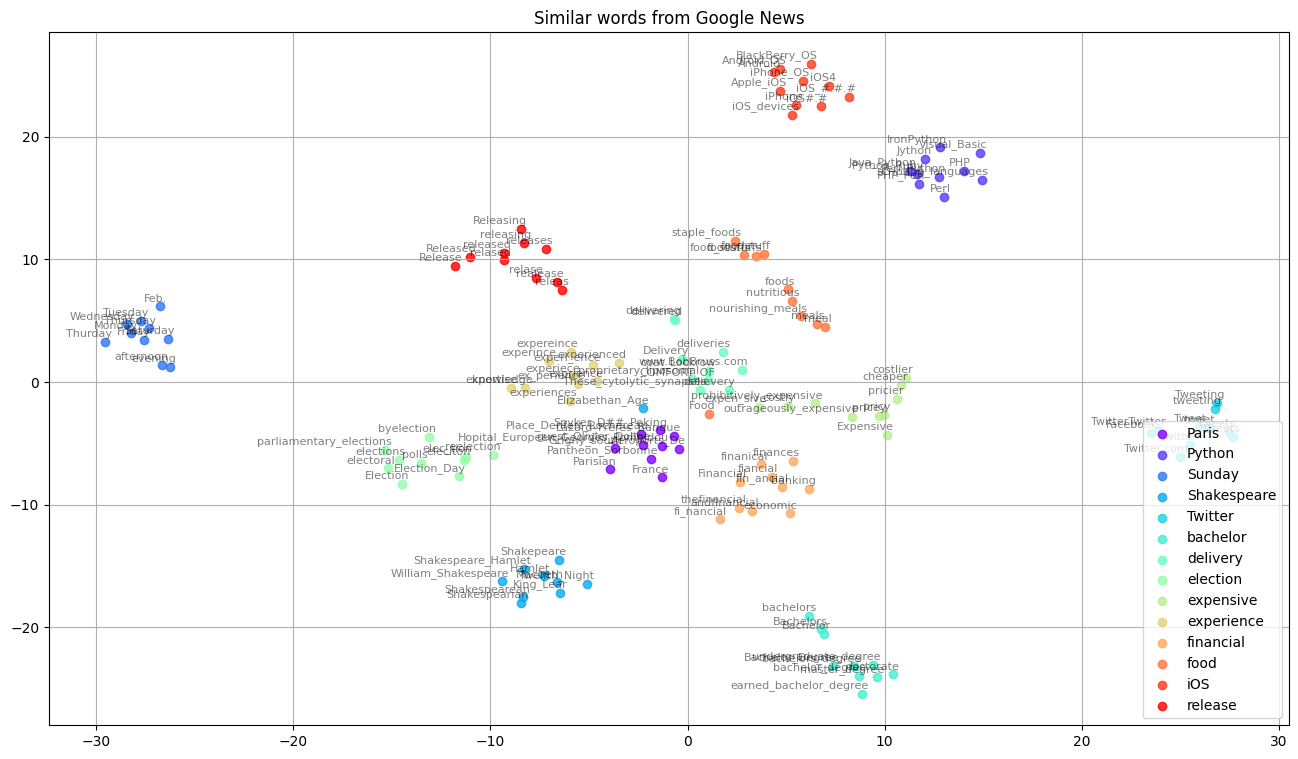

In [ ]:
tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.8)

Алгоритм Word2Vec успішно виявив і згрупував схожі слова в семантичні кластери. Ця модель показує високу здатність розпізнавати контексти та взаємозв'язки між словами на основі їх використання в тексті.


Застосування t-SNE для зменшення розмірності також дозволило візуально оцінити якість кластеризації, підтверджуючи ефективність Word2Vec у завданні семантичного аналізу текстових даних.

In [ ]:
del model

# Ембединги як ознаки

Word embeddings можна використовувати як ознаки для тренування моделей

Переваги: можливість репрезентувати семантичні відношення між словами у векторному просторі. Це дозволяє моделям легше розуміти семантичну схожість між словами й використовувати цю інформацію для різних завдань. (є потужним інструментом)

In [ ]:
# Створимо функцію, яка, маючи список токенів, буде отримувати їх векторне представлення.

# Далі будемо повертати усереднене значення всіх векторів.
# Це робиться тому, що кожне речення буде представлено різною кількістю токенів,
# але для тренування моделі кожне вхідне речення має містити однакову кількість ознак.
# Саме тому ми усереднюємо значення векторів для всіх токенів, щоб отримати представлення відгуку розмірності (1, кількість_вимірів_алгоритму).

# Якщо метод усереднення має значення mean, функція обчислює середнє значення векторів. Якщо методом усереднення є sum, функція обчислює суму векторів.

# np.nanmean і np.nansum використовуються для обробки випадків, коли отриманий вектор для токена має значення NaN.
# Це можливо у випадку, коли даний токен відсутній у словнику моделі.

def tok2vec(tokens, source:str, avg:str):
    """
    Given a list of tokens, return their vector representation.
    Args:
        tokens: List(str) tokenized input
        source: embedding algorithm to use with the WordEmbedding object
        avg: vectors averaging method - `sum` or `mean` of all vectors
    """
    vects = word_embedding.get_vectors(source=source, words=tokens)

    if avg == 'mean':
        return np.nanmean(vects, axis=0)
    elif avg == 'sum':
        return np.nansum(vects, axis=0)
    else:
        raise ValueError('Select correct averaging method: sum or mean')

In [ ]:
# Оновимо об’єкт WordEmbedding. Поекспериментуємо і цього разу попрацюємо з претренованими векторами Word2Vec.
word_embedding = WordEmbedding()

In [ ]:
gc.collect()

8249

In [ ]:
source = 'word2vec'

word_embedding.load(source=source, file_path=word2vec_file_path)

2024-11-28 23:40:58.554533 start: loading word2vec
2024-11-28 23:41:56.020507 end: loading word2vec


In [ ]:
# Розділимо дані на тренувальні й тестові.
# Створимо матриці ознак навчальної та тестової вибірок таким чином: токенізуємо змінну text_normalized,
# використавши об’єкт-токенайзер бібліотеки nltk — word_tokenize.
# Після цього отримаємо векторні представлення наших відгуків, використавши функцію tok2vec.
train_idxs = df.sample(frac=0.8, random_state=42).index
test_idxs = [idx for idx in df.index if idx not in train_idxs]

X_train = df.loc[train_idxs, 'text_normalized'].apply(
    word_tokenize).apply(lambda x: tok2vec(x, source, 'mean')).to_numpy()

X_test = df.loc[test_idxs, 'text_normalized'].apply(
    word_tokenize).apply(lambda x: tok2vec(x, source, 'mean')).to_numpy()

X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)

y_train = df.loc[train_idxs, 'sentiment']
y_test = df.loc[test_idxs, 'sentiment']

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
predictions = model.predict(X_test)

print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.8071177944862156


Отримання значення AUC, яке рівне 0.8, для натренованої моделі є досить гарним результатом і свідчить про те, що модель виявила досить високу прогностичну здатність.


Отримання гіршого результату з використанням усереднених векторів Word2Vec як ознак для логістичної регресії порівняно з використанням методу Bag of Words може мати кілька причин.


Під час усереднення векторів Word2Vec усі слова мають однаковий ваговий вплив на підсумковий ознаковий вектор. Однак деякі слова можуть мати більший семантичний вплив на текст, ніж інші. Метод Bag of Words може враховувати це, якщо якісь слова є більш повторювані за інші в певному відгуці.


Також використання усереднених векторів Word2Vec може призвести до меншої розмірності ознакового простору порівняно з методом Bag of Words. Менший розмір ознакового простору може спричинити втрату інформації та зменшення точності моделі.


👉🏻 Отже, хоча використання усереднених векторів Word2Vec може бути корисним для багатьох завдань у сфері обробки природної мови, для певних завдань він може бути менш ефективним порівняно з іншими методами, такими як Bag of Words.

In [ ]:
# Для подальшої роботи окремо збережемо токенізоване представлення text_normalized.
text_tokenized = df['text_normalized'].apply(word_tokenize).to_list()

In [ ]:
# Щоб навчити модель Doc2Vec, використовуючи бібліотеку gensim, нам потрібен тегований документ,
# який можна створити за допомогою models.doc2vec.TaggedDocument().
def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

In [ ]:
text_tokenized_tagget = list(tagged_document(text_tokenized))

In [ ]:
text_tokenized_tagget[3]

TaggedDocument(words=['try', 'differant', 'brand', 'juice', 'imply', 'get', 'relief', 'arthritis', 'pain', 'save', 'money', 'buy', 'tylenol', 'brand', 'good', 'bland', 'taste', 'nothing', 'pain'], tags=[3])

In [ ]:
# Створимо й натренуємо модель Doc2Vec.
model_Doc2Vec = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=5, epochs=200)

model_Doc2Vec.build_vocab(text_tokenized_tagget)

model_Doc2Vec.train(text_tokenized_tagget, total_examples=model_Doc2Vec.corpus_count, epochs=model_Doc2Vec.epochs)

In [ ]:
model_Doc2Vec.infer_vector(text_tokenized[0]).shape

(300,)

In [ ]:
X = [model_Doc2Vec.infer_vector(x) for x in text_tokenized]

In [ ]:
X_train = [X[idx] for idx in train_idxs]
X_test = [X[idx] for idx in test_idxs]

X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

In [ ]:
# тренування й тестування
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print('AUC: ', roc_auc_score(y_test, predictions))

NameError: name 'LogisticRegression' is not defined

Порівнюючи ефективність двох підходів до представлення текстів у векторній формі — використання усереднених претренованих векторів Word2Vec і тренування власних ембедингів Doc2Vec — бачимо перевагу методу Doc2Vec. Дійсно, при тренуванні модель Doc2Vec вивчила специфічну для набору даних лексику, що дало перевагу над моделлю Word2Vec.